In [6]:
import os
import numpy as np
import scipy
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import skfmm
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import cv2
import imageio.v3 as iio
from scipy.io import loadmat
import time

In [7]:
def ffd_lattice(base_xy, m, n):

    x_min = np.min(base_xy[:,0])
    x_max = np.max(base_xy[:,0])
    y_min = np.min(base_xy[:,1])
    y_max = np.max(base_xy[:,1])

    x = np.linspace(x_min, x_max, m)
    y = np.linspace(y_min, y_max, n)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    P = np.stack((xx, yy), axis=-1)

    u = (base_xy[:,0]-x_min)/(x_max-x_min)
    v = (base_xy[:,1]-y_min)/(y_max-y_min)

    return P, u, v


In [8]:
def bernstein(xx, m, i):
    b = scipy.special.binom(m, i) * xx**i * (1-xx)**(m-i)
    return b

def deform(im, scale=20):
    rez = im.shape[0]
    xx, yy = np.mgrid[:rez, :rez]
    base_xy = np.stack((xx, yy), axis=-1).reshape(-1,2)
    m, n = rez, rez
    P, u, v = ffd_lattice(base_xy, m, n)
    # Deform grid points by perturbing control points
    P_ = P + np.random.normal(scale=scale, size=P.shape)
    # # Apply sudden change to one point
    # i = np.random.choice(P.shape[0])
    # j = np.random.choice(P.shape[1])
    # P_[i,j] = P_[i,j] + np.random.normal(scale=10*scale, size=2)
    new_xy = np.zeros_like(base_xy, dtype=np.float64)
    for i in range(m):
        for j in range(n):
            new_xy += bernstein(u, m-1, i).reshape(-1,1) * \
                      bernstein(v, n-1, j).reshape(-1,1) * P_[j,i].reshape(1,2)
    # Interpolate a new image from deformed grid points
    new_im = griddata(new_xy, im.flatten(), (xx, yy), method='nearest')
    # # Apply Gaussian filter
    # new_im = gaussian_filter(new_im, sigma=rez/32)
    return new_im.T

def nucleate_hole(im, padding=8):
    I = (im > 0) # indicator function
    ci = np.random.randint(padding, rez-padding)
    cj = np.random.randint(padding, rez-padding)
    if I[ci, cj]:
        mean = [ci, cj]
        sii = np.random.normal(2, 0.1)**2
        sjj = np.random.normal(2, 0.1)**2
        sij_low = -(sii*sjj)**.5 + 1e-7
        sij_high = (sii*sjj)**.5 - 1e-7
        sij = np.maximum(np.minimum(np.random.normal(0, 1), sij_high), sij_low) # ensures positive semi-definiteness
        cov = np.array([[sii, sij],
                        [sij, sjj]])
        ii = np.linspace(0, rez-1, rez)
        jj = np.linspace(0, rez-1, rez)
        iv, jv = np.meshgrid(ii, jj, indexing='ij')
        coords = np.stack((iv, jv), axis=-1).reshape(-1,2)
        p = np.zeros(coords.shape[0])
        scale = np.random.uniform(0, 2)#Hole Size second digit
        for i, coord in enumerate(coords):
            p[i] = (im[ci, cj]+scale) * np.exp(-0.5 * (coord-mean) @ np.linalg.inv(cov) @ np.transpose(coord-mean))
        new_im = im - p.reshape(rez, rez)
        # height = 80
        # rho = np.random.uniform()
        # z = ((iv-mean[0])/cov[0,0])**2 + ((jv-mean[1])/cov[1,1])**2 \
        #     - 2 * rho * np.multiply( (iv-mean[0]),  (jv-mean[1]) ) / ( cov[0,0]*cov[1,1] )
        # p = height *im[ci, cj] * 1/(2*np.pi*cov[0,0]*cov[1,1]*np.sqrt(1-rho**2))*np.exp( - z/(2*(1-rho**2)))
        # new_im = im - p
        plt.figure()
        plt.imshow(new_im>0)
        plt.colorbar()
        plt.title(cov)
        plt.savefig('1.png')
        plt.close()
    else:
        new_im = im
    return new_im


In [9]:
data_dir = 'data'
# nominal_data_raw = np.load('/home/grads/c/calzheng/Downloads/data/Auxetic.png'.format(data_dir))
#nominal_data_raw = iio.imread('/home/grads/c/calzheng/Downloads/data/Auxetic.png')
nominal_data_raw = loadmat(r'/Users/calzheng/Desktop/Data/Geometries.mat')
nominal_data_raw = nominal_data_raw['Geometries']
indices = np.arange(0, nominal_data_raw.shape[2], 1)
# nominal_data_raw = nominal_data_raw[:,:,indices]




# nominal_data_raw = cv2.resize(nominal_data_raw, (64, 64))
# # nominal_data_raw = nominal_data_raw.reshape((-1, 64, 64))
# nominal_data_raw = np.transpose(nominal_data_raw,(2,0,1))
# nominal_npy_path =  nominal_data_raw



indices = np.load('rand_indices.npy')
# selected_slices = selected_slices[:,:,rand_indices]
# Preallocate an array for the resized slices
selected_slices = nominal_data_raw[:,:,indices]

selected_slices = selected_slices[:,:,150:200]
resized_slices = np.empty((selected_slices.shape[2], 64, 64), dtype=selected_slices.dtype)

# Resize each selected slice
for i in range(selected_slices.shape[2]):
    slice = selected_slices[:,:,i]
    resized_slices[i,:,:] = cv2.resize(slice, (64, 64))

# If needed, transpose to adjust shape, depending on your subsequent use-case
nominal_data_raw = resized_slices
nominal_data_raw1 = resized_slices
# nominal_data_raw = nominal_data_raw[:5]
deformed_npy_path = '/Users/calzheng/Desktop/Data/150_200_300_GeoDeformed(DF5,H2).npy'.format(data_dir)
# nominal_data_raw=nominal_data_raw[9:10]
# n_nominal = nominal_data_raw.shape[0]

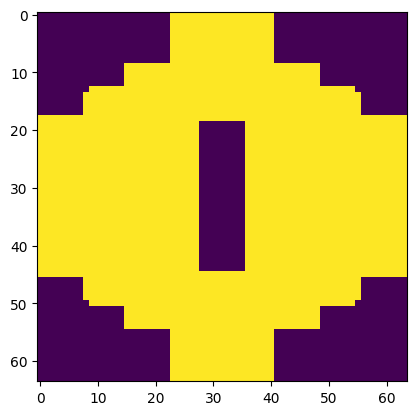

In [10]:
plt.imshow(nominal_data_raw[40,:, :])


In [11]:
np.min(nominal_data_raw[0, :, :])

0

In [12]:
 n_nominal = nominal_data_raw.shape[0]

#nominal_data_raw = nominal_data_raw[]
#nominal_data_raw

In [13]:

if not os.path.exists(deformed_npy_path):
        rez = nominal_data_raw.shape[1]
        nominal_data_raw = nominal_data_raw / (rez/2)
        n_variants_per_nominal = 300
        deform_scale = rez/5

        # fig_dir = '{}/figures'.format(data_dir)
        # create_dir(fig_dir)

        deformed_data_raw = np.zeros((n_nominal, n_variants_per_nominal, rez, rez))

        for i in tqdm(range(n_nominal)):

            nominal_shape = nominal_data_raw[i]
            # plot_image(nominal_shape, '{}/{}.png'.format(fig_dir, i))

            for j in range(n_variants_per_nominal):
                # start_time = time.time()
                deformed_shape = deform(nominal_shape, scale=deform_scale)
                # end_time1 = time.time()
#                 deformed_data_raw[i,j] = deformed_shape
                deformed_data_raw[i,j] = nucleate_hole(deformed_shape)
                # end_time2 = time.time()
                # print(end_time1 - start_time, end_time2 - end_time1)
                # plt.figure()
                # plt.imshow(deformed_data_raw[i,j]>0)
                # plt.savefig('{}/{}_{}.png'.format(fig_dir, i, j))
                # plt.close()

        # # Convert shapes to SDF
        # nominal_data_raw = (nominal_data_raw > 0) * 2. - 1.
        # deformed_data_raw = (deformed_data_raw > 0) * 2. - 1.
        # nominal_data = np.zeros((nominal_data_raw.shape[0], rez, rez))
        # deformed_data = np.zeros(deformed_data_raw.shape[:2]+(rez, rez))
        # for i, design in tqdm(enumerate(nominal_data_raw)):
        #     arr = skfmm.distance(design)
        #     nominal_data[i] = np.array(Image.fromarray(arr).resize((rez, rez)))
        # for i, designs in tqdm(enumerate(deformed_data_raw)):
        #     for j, design in enumerate(designs):
        #         arr = skfmm.distance(design)
        #         deformed_data[i,j] = np.array(Image.fromarray(arr).resize((rez, rez)))
        # nominal_data /= np.abs(nominal_data).max()
        # deformed_data /= np.abs(deformed_data).max()
        # deformed_data1 = skfmm.distance(deformed_data)

        # if np.max(deformed_data1)>abs(np.min(deformed_data1)):
        #     limit = np.max(deformed_data1)
        # else:
        #     limit = abs(np.min(deformed_data1))



        # deformed_data1 = deformed_data1/limit

        # np.save(nominal_npy_path, nominal_data)
        # np.save(deformed_npy_path, deformed_data1)

100%|██████████| 50/50 [2:39:45<00:00, 191.71s/it]  


In [14]:
deformed_data_raw = deformed_data_raw>0
deformed_data_raw = deformed_data_raw*2-1
np.save(deformed_npy_path, deformed_data_raw)

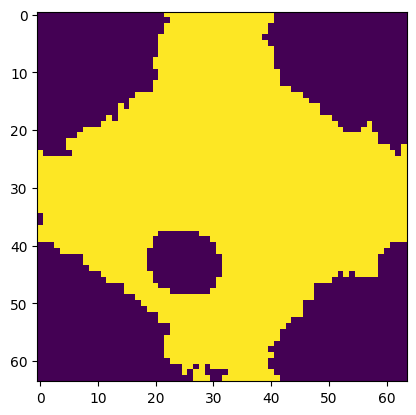

In [15]:
plt.imshow(deformed_data_raw[1][1])

In [16]:
nominal_data_raw1 = nominal_data_raw1>0
nominal_data_raw1 = nominal_data_raw1*2-1

In [18]:
np.save('/Users/calzheng/Desktop/Data/150_200_300_nominal.npy', nominal_data_raw1)

In [ ]:
 deformed_data1.shape

In [ ]:
 deformed_data1[1,1,:,:].shape

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

# Iterate over the grid and plot each subplot
for i in range(10):
    for j in range(10):
        # Select the subplot
        ax = axes[i, j]

        # Plot the image
        ax.imshow(deformed_data1[0,10*i+j]>0)  # 'cmap' can be adjusted depending on your data

        # Optionally, remove the axis labels for clarity
        ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
deformed_data1

In [ ]:
deformed_data.shape

In [ ]:
# deformed_data1 = skfmm.distance(deformed_data,narrow=45,dx=1)
# deformed_data1 = deformed_data1/45
# deformed_data1 = deformed_data1.reshape(deformed_data1.shape[1], 128, 128, 1)
# plt.imshow(deformed_data1[1, :, :,:])

In [ ]:
print(np.min(deformed_data1))
print(np.max(deformed_data1))


In [ ]:
ND = skfmm.distance(nominal_data_raw)

if np.max(ND)>abs(np.min(ND)):
        limit = np.max(ND)
else:
        limit = abs(np.min(ND))



ND = ND/limit

In [ ]:
print(np.max(ND))

In [ ]:
gaussian_image = cv2.GaussianBlur(ND, (21, 21), 10)

In [ ]:
np.max(ND)

In [ ]:
gaussian_image10

In [ ]:
plt.imshow(gaussian_image[0, :, :])

In [ ]:
plt.imshow(ND[0, :, :])